We are going to implement the char rnn from karpathy here using pytorch
ref: https://gist.github.com/karpathy/d4dee566867f8291f086
ref: http://karpathy.github.io/2015/05/21/rnn-effectiveness/
        
We are going to use the karamaziov text as innput

In [98]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [2]:
import numpy as np

In [422]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = open("karamazov.lines.txt", 'r').read()
chars = list(set(data))

In [425]:
# We will use Shakespeare Sonnet 2
data = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold."""
chars = list(set(data))

In [426]:


data_size, vocab_size = len(data), len(chars)
print ('data has %d characters, %d unique.' % (data_size, vocab_size))

char2index = { c:i for i,c in enumerate(chars) }
index2char = { i:c for i,c in enumerate(chars) }


data has 628 characters, 40 unique.


In [427]:
def sequence_to_variable(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return Variable(tensor)

def var_to_str(v) :
    return "".join([ index2char[ int(v[i]) ] for i in range(len(v)) ])

In [428]:
class charRNN(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size):
        super(charRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, input_size).cuda()
        self.gru = nn.GRU(input_size, hidden_size).cuda()
        self.linear = nn.Linear( hidden_size, vocab_size ).cuda()

    def forward(self, input, hidden):
        embedded = self.embedding(input.view(-1)) #.view(1, 1, -1) #.view((1, -1))
        
        output = embedded.view(input.shape[0], input.shape[1], -1) #we need the same shape as input
        output, hidden = self.gru(output, hidden)
        output = self.linear( output.view(-1, output.size(2)) ) #we done need the sequence dim
        scores = F.log_softmax(output, dim=1)
        return scores.view(input.shape[1], input.shape[0], -1), hidden
        #return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [429]:
class MiniBatch : #makes a minibath at a time from the data string
    def __init__(self, data, seq_len, batch_size ) :
        self.data = data
        self.data_len = len(data)
        self.seq_len = seq_len
        self. batch_size = batch_size
                 
        self.batch_length = (seq_len * batch_size)
        self.N = int(self.data_len/self.batch_length)
        self.max = self.data_len - self.batch_length #generate upto the last block
        self.p = 0 #starting index
        
    def batch(self) : #returns the next batch
        if self.p > self.max :
            self.p = 0
        data = self.data
        p = self.p        
        length = self.batch_length
        self.p = p+length #increment p
        
        sequence = torch.LongTensor([ char2index[c] for c in data[p:p+length] ])
        y = Variable( torch.LongTensor([ char2index[c] for c in data[p+1:p+length+1] ])).view(self.batch_size, -1) # +1
        batch = Variable( sequence ).view(self.seq_len, self.batch_size, -1 )
        #if use_cuda :
        return batch.cuda(), y.cuda()
        #else :
        #    return batch, y
    

In [343]:
minibatch = MiniBatch( data, 25, 1)

In [348]:
for i in range(minibatch.N) :
    a, y = minibatch.batch()

In [454]:
a, y = minibatch.batch()

In [455]:
y[0].shape

torch.Size([10])

In [456]:
var_to_str(y[0])

'l worth he'

In [301]:
a.size(), y.size()

(torch.Size([25, 1, 1]), torch.Size([1, 25]))

In [302]:
use_cuda = False
input_size = 10
hidden_size = 100
crnn = charRNN( vocab_size, input_size, hidden_size)

In [490]:
a.type

<bound method Variable.type of Variable containing:
(0 ,.,.) = 
   6

(1 ,.,.) = 
  13

(2 ,.,.) = 
  34

(3 ,.,.) = 
   2

(4 ,.,.) = 
   2

(5 ,.,.) = 
  31

(6 ,.,.) = 
  12

(7 ,.,.) = 
   0

(8 ,.,.) = 
   3

(9 ,.,.) = 
   8
[torch.cuda.LongTensor of size 10x1x1 (GPU 0)]
>

In [304]:
batch_size = a.shape[1]
o = crnn( a, Variable(torch.zeros(1,batch_size,hidden_size)) )

In [305]:
o.shape

torch.Size([1, 25, 107])

In [306]:
tag_scores = F.log_softmax(o, dim=2)

In [307]:
tag_scores.shape, y.shape

(torch.Size([1, 25, 107]), torch.Size([1, 25]))

In [308]:
loss = nn.NLLLoss()

torch.Size([25])

In [315]:
s = y.view(-1).shape[0]
l = loss(tag_scores.view(s, -1), y.view(-1))

In [316]:
l

Variable containing:
 4.6524
[torch.FloatTensor of size 1]

In [430]:
use_cuda = True
input_size = 10
hidden_size = 100
model = charRNN( vocab_size, input_size, hidden_size).cuda()

In [441]:
batch_size = 1
seq_len = 10
minibatch = MiniBatch( data, seq_len, batch_size)

In [544]:
criterion = nn.NLLLoss().cuda()

In [532]:
#optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [434]:
hidden = Variable(torch.zeros(1,batch_size,hidden_size)).cuda()

In [547]:
N = 1
loss_db = np.zeros(N)
i = 0
for epoch in range(N):   
    a, y = minibatch.batch()
    scores, hidden = model( a, hidden )
    
    optimizer.zero_grad()
    s = y.view(-1).shape[0]
    loss = criterion(scores.view(s, -1), y.view(-1))
    
    #print(l)
    #l.backward(retain_graph=True)
    #loss.backward(retain_graph=True)
    loss.backward()
    optimizer.step()
    
    #loss_db[i] = int(loss)
    #i += 1
    

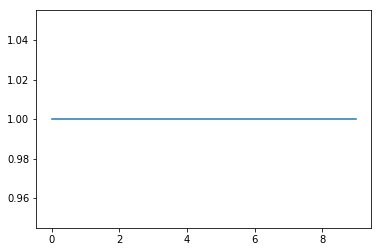

In [536]:
plt.plot(loss_db)

In [463]:
scores.shape, a.shape

(torch.Size([1, 10, 40]), torch.Size([10, 1, 1]))

In [466]:
var_to_str(a[:,0,0])

'tless prai'

In [ ]:
s, h = model( a, h )

In [486]:
b = a[0].view(1,1,1).cpu()

In [498]:
b = Variable(torch.LongTensor([j]).view(1,1,1)).cuda()

RuntimeError: already counted a million dimensions in a given sequence. Most likely your items are also sequences and there's no way to infer how many dimension should the tensor have

In [499]:
j

Variable containing:
 20
[torch.cuda.LongTensor of size 1 (GPU 0)]

In [500]:
s,h = model(j.view(1,1,1), hidden)

In [520]:
b = j

In [477]:
i,j = torch.max( s[0][0], 0 )

In [510]:
h = hidden

In [521]:
store = []
for _ in range(100) :
    s,h = model(b.view(1,1,1), h)
    i,b = torch.max( s[0][0], 0 )
    store.append(int(b))

In [522]:
''.join([ index2char[i] for i in store ])

'm mee thy beauty shy beauty shy beauty shy beauty shy beauty shy beauty shy beauty shy beauty shy be'

In [529]:
N = 100
for epoch in range(N):   
    c, v = minibatch.batch()
    print( var_to_str(v[0]), end='')

deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st ihen forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This 

In [525]:
v.shape

torch.Size([1, 10])

In [540]:
N = 100
for epoch in range(N):   
    a, y = minibatch.batch()
    scores, h = model( a, hidden )
    optimizer.zero_grad()
    s = y.view(-1).shape[0]

In [101]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = torch.Tensor([0])
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in variables)
        context_idxs = [word_to_ix[w] for w in context]
        context_var = autograd.Variable(torch.LongTensor(context_idxs))

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_var)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a variable)
        loss = loss_function(log_probs, autograd.Variable(
            torch.LongTensor([word_to_ix[target]])))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        total_loss += loss.data
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]
[
 518.9155
[torch.FloatTensor of size 1]
, 
 516.3281
[torch.FloatTensor of size 1]
, 
 513.7601
[torch.FloatTensor of size 1]
, 
 511.2106
[torch.FloatTensor of size 1]
, 
 508.6778
[torch.FloatTensor of size 1]
, 
 506.1604
[torch.FloatTensor of size 1]
, 
 503.6585
[torch.FloatTensor of size 1]
, 
 501.1724
[torch.FloatTensor of size 1]
, 
 498.6984
[torch.FloatTensor of size 1]
, 
 496.2386
[torch.FloatTensor of size 1]
]


In [169]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [551]:
21 % 10

1